In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [11]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

In [2]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


###  MODELING

#### 1. create_date sorting 적용 케이스

In [3]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [4]:
features=['weekend_yn', 'sido_cd', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

49


In [5]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features]=scaler.fit_transform(df_raw[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [7]:
sequence_length = 15
X, y, dates = create_sequences(df_raw, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=11, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20796, 15, 49)
X_test shape: (5199, 15, 49)
y_train shape: (20796,)
y_test shape: (5199,)


#### 1-1. RNN Modeling

In [9]:
# RNN 모델
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1))
# 모델 compile
rnn_model.compile(optimizer='adam', loss='mse')

# 학습 모델
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss = rnn_model.evaluate(X_test, y_test)

# 예측값 생성
rnn_predictions = rnn_model.predict(X_test)

# 평가지표
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)

print('RNN Test MAE:', rnn_mae)
print('RNN Test Loss:', rnn_loss)
print('RNN Test MSE:', rnn_mse)
print('RNN Test R^2:', rnn_r2)

/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8612 - val_loss: 4.0042
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.0751 - val_loss: 4.0138
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8375 - val_loss: 3.4329
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.8366 - val_loss: 3.7583
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9760 - val_loss: 4.6258
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7194 - val_loss: 3.1556
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5045 - val_loss: 3.1936
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8057 - val_loss: 3.4251
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3813 - val_loss: 3.3046
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.9810 - val_loss: 3.2204
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7431 - val_loss: 3.1534
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

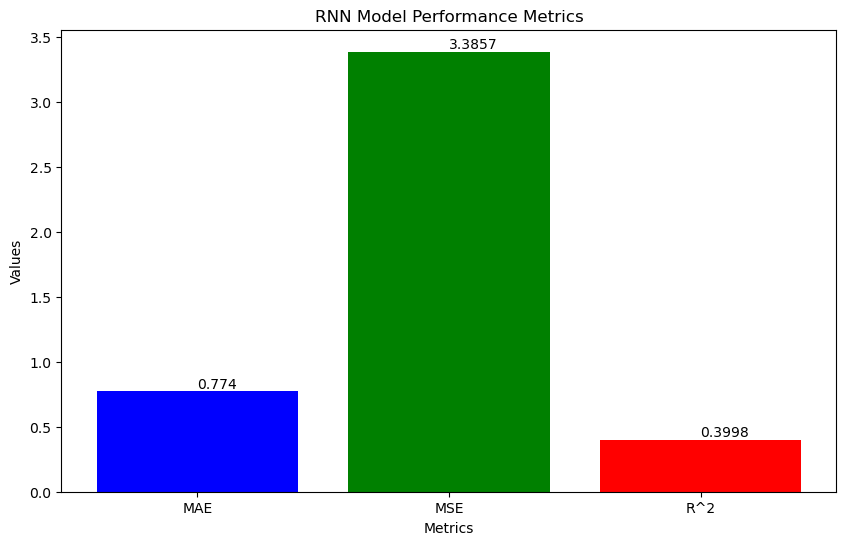

In [10]:
# 성능 평가 지표를 리스트로 정리
model = ['RNN', 'RNN', 'RNN']
metrics = ['MAE', 'MSE', 'R^2']
values = [rnn_mae, rnn_mse, rnn_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

#### 1-2. LSTM Modeling

In [12]:
# LSTM 모델 빌드
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 평가
lstm_loss = lstm_model.evaluate(X_test, y_test)
print('LSTM Test Loss:', lstm_loss)

# 예측값 생성
lstm_predictions = lstm_model.predict(X_test)

# 추가 평가 지표
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print('RNN Test MAE:', lstm_mae)
print('RNN Test MSE:', lstm_mse)
print('RNN Test R^2:', lstm_r2)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.5628 - val_loss: 3.5746
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.5264 - val_loss: 3.5377
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2265 - val_loss: 3.3950
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.6333 - val_loss: 3.6239
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7408 - val_loss: 3.6840
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.2030 - val_loss: 3.1249
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7179 - val_loss: 3.0712
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1735 - val_loss: 3.4809
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3165 - val_loss: 3.0605
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1990 - val_loss: 3.0120
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.2596 - val_loss: 3.1182
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.

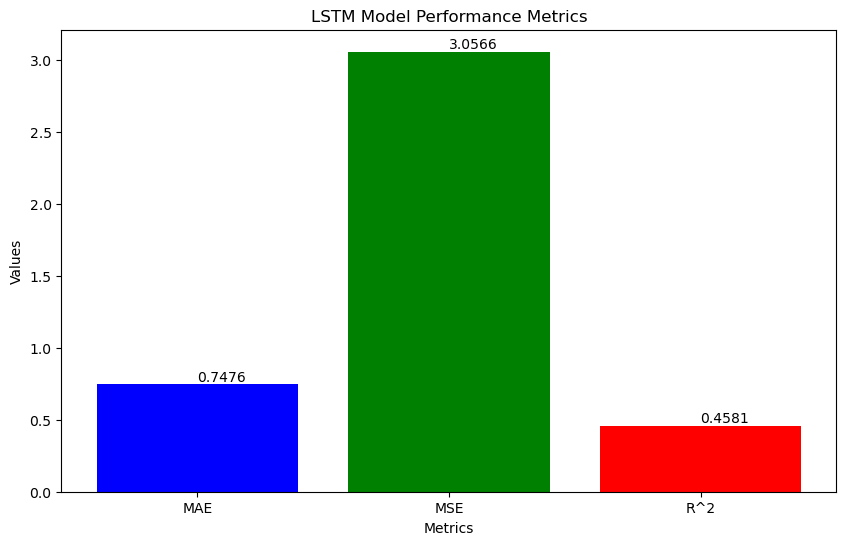

In [13]:
# 성능 평가 지표를 리스트로 정리
model = ['LSTM', 'LSTM', 'LSTM']
metrics = ['MAE', 'MSE', 'R^2']
values = [lstm_mae, lstm_mse, lstm_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()

#### 1-3. RandomForest Modeling

In [15]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

In [17]:
# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
rf_model.fit(X_train_flat, y_train)

# RF 모델
rf_predictions = rf_model.predict(X_test_flat)

# 추가 평가지표 계산
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest Test MAE:', rf_mae)
print('RandomForest Test MSE:', rf_mse)
print('RandomForest Test R^2:', rf_r2)

RandomForest Test MAE: 0.8224735526062704
RandomForest Test MSE: 3.6592141180996345
RandomForest Test R^2: 0.35129723905551047


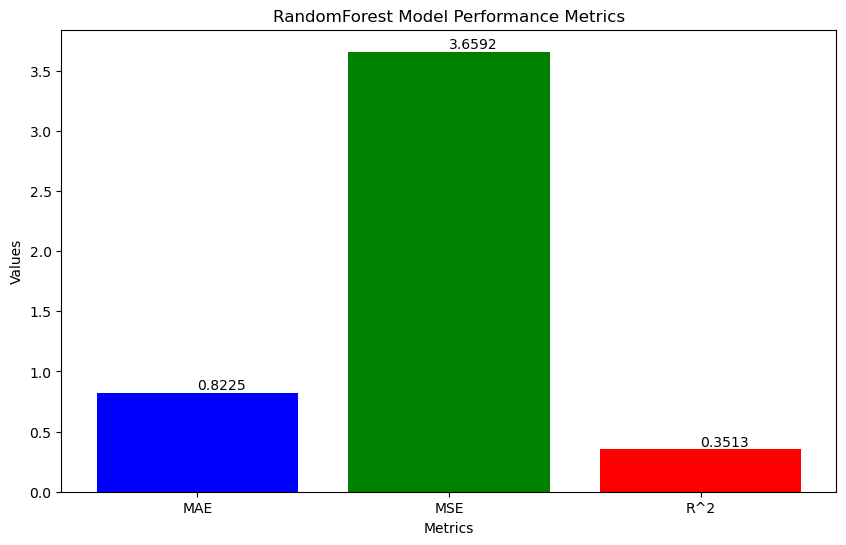

In [18]:
# 성능 평가 지표를 리스트로 정리
model = ['RandomForest', 'RandomForest', 'RandomForest']
metrics = ['MAE', 'MSE', 'R^2']
values = [rf_mae, rf_mse, rf_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RandomForest Model Performance Metrics')
plt.show()

#### 1-4. XGBoostRegressor Modeling

In [20]:
# XGBoost 모델 빌드
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=11)
xgb_model.fit(X_train_flat, y_train)

# XGBoost 모델
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# 추가 평가지표 계산
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost Test MAE:', xgb_mae)
print('XGBoost Test MSE:', xgb_mse)
print('XGBoost Test R^2:', xgb_r2)

XGBoost Test MAE: 0.7538204990219832
XGBoost Test MSE: 3.310897762320855
XGBoost Test R^2: 0.41304653882980347


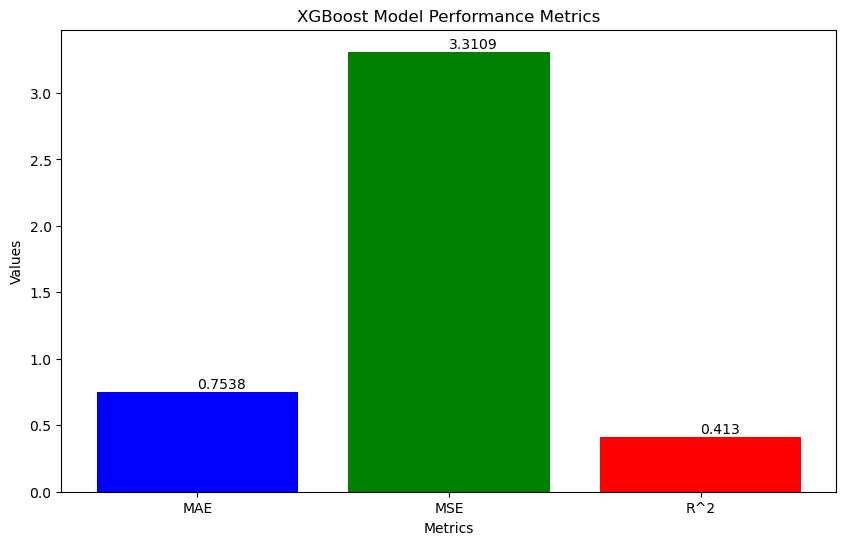

In [22]:
# 성능 평가 지표를 리스트로 정리
model = ['XGBoost', 'XGBoost', 'XGBoost']
metrics = ['MAE', 'MSE', 'R^2']
values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost Model Performance Metrics')
plt.show()

#### 1-5. 시각화로 나타내기

#### 실제값과 모델별 예측값 확인하기

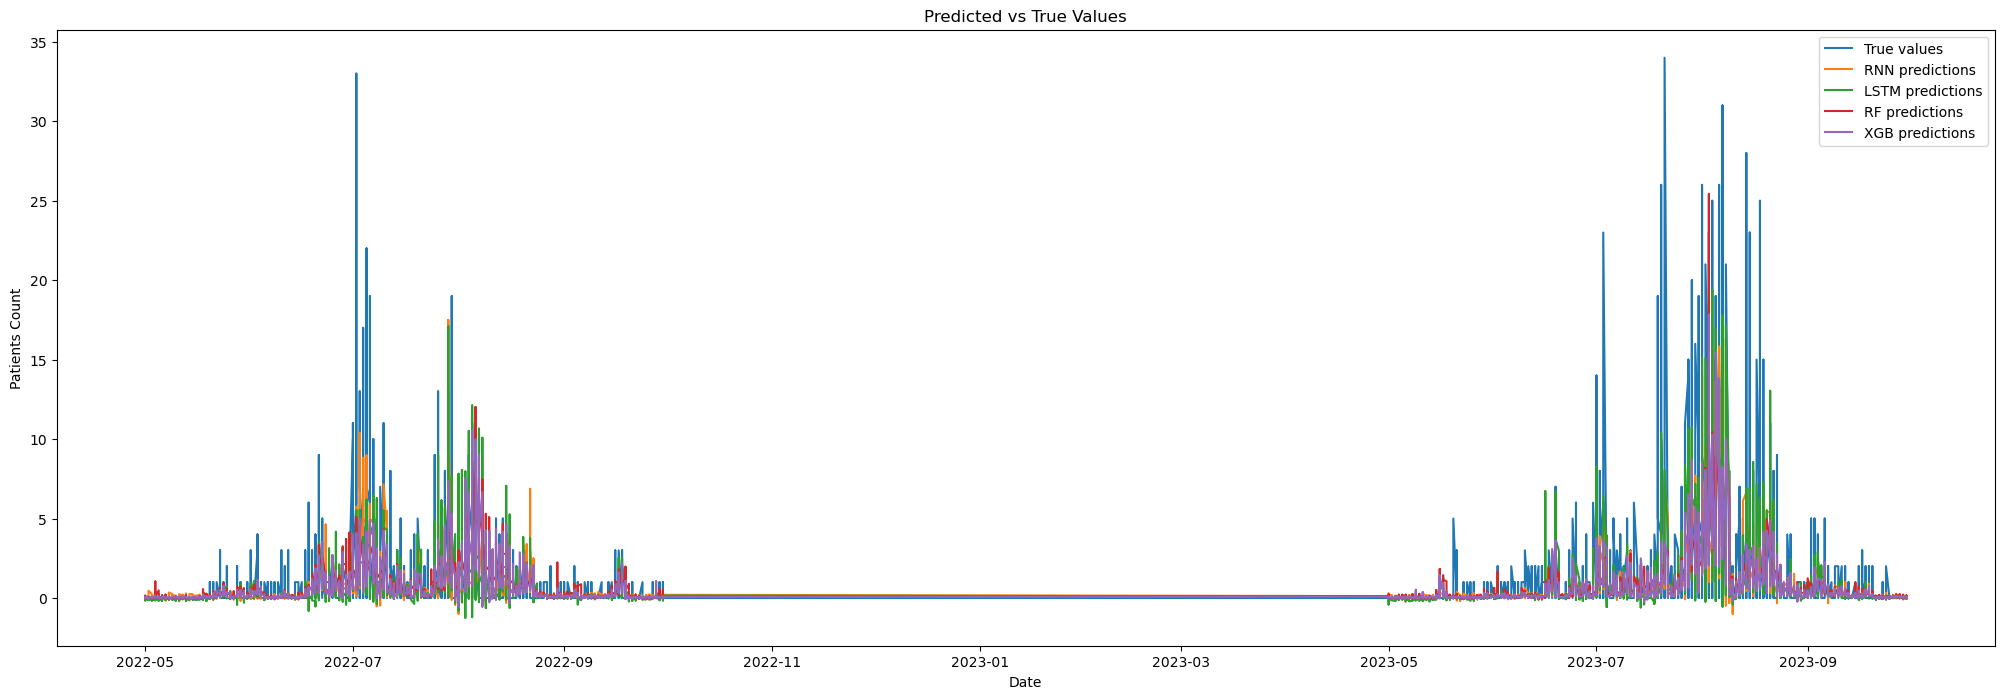

In [23]:
# 결과 시각화
plt.figure(figsize=(25, 8))
plt.plot(dates_test, y_test, label='True values')
plt.plot(dates_test, rnn_predictions, label='RNN predictions')
plt.plot(dates_test, lstm_predictions, label='LSTM predictions')
plt.plot(dates_test, rf_predictions, label='RF predictions')
plt.plot(dates_test, xgb_predictions, label='XGB predictions')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

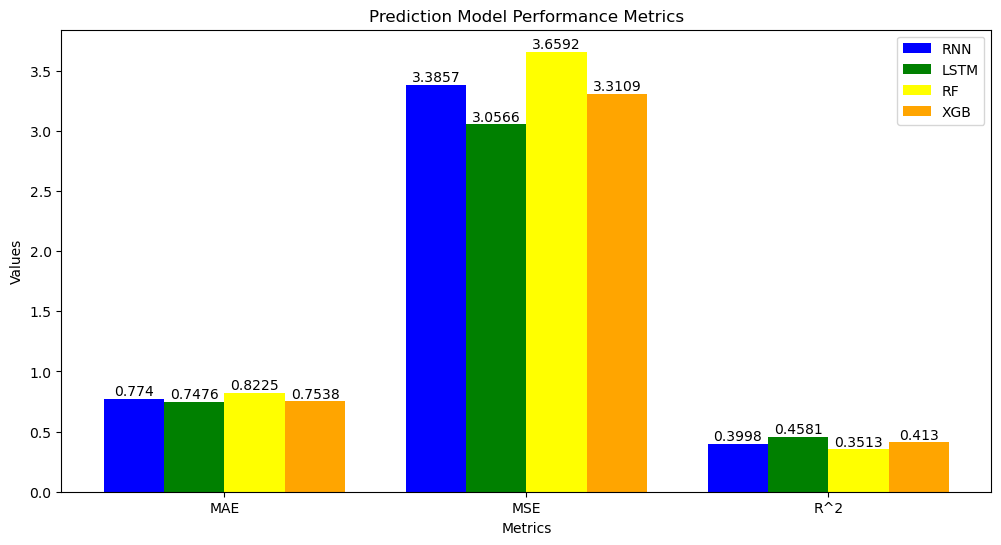

In [30]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
rnn_values = [rnn_mae, rnn_mse, rnn_r2]
lstm_values = [lstm_mae, lstm_mse, lstm_r2]
rf_values = [rf_mae, rf_mse, rf_r2]
xgb_values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('Prediction Model Performance Metrics.png')
plt.show()

#### 2. create_date sorting / feature selection 적용 케이스

- feature selection 목록은 SelectKBest에서 추출한 15개 feature 정보로 테스트함

In [7]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [8]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

In [9]:
# selectKBest 변수 지정
features=['max_ta', 'mean_ta', 'max_tafeel', 'mean_tafeel', 'ta_max_am', 'ta_mean_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2',
     'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

15


In [10]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features]=scaler.fit_transform(df_raw[features])

# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

In [12]:
sequence_length = 15
X, y, dates = create_sequences(df_raw, features, target, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=11, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20796, 15, 15)
X_test shape: (5199, 15, 15)
y_train shape: (20796,)
y_test shape: (5199,)


#### 2-1. RNN Modeling

In [13]:
# RNN 모델
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
rnn_model.add(Dense(1))
# 모델 compile
rnn_model.compile(optimizer='adam', loss='mse')

# 학습 모델
rnn_history = rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# 모델 평가
rnn_loss = rnn_model.evaluate(X_test, y_test)

# 예측값 생성
rnn_predictions = rnn_model.predict(X_test)

# 평가지표
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_r2 = r2_score(y_test, rnn_predictions)

print('RNN Test MAE:', rnn_mae)
print('RNN Test Loss:', rnn_loss)
print('RNN Test MSE:', rnn_mse)
print('RNN Test R^2:', rnn_r2)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0372 - val_loss: 3.9318
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8629 - val_loss: 4.0246
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5086 - val_loss: 4.0045
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7418 - val_loss: 3.8446
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.9673 - val_loss: 4.2853
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4040 - val_loss: 3.8916
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8813 - val_loss: 3.9996
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4263 - val_loss: 3.8265
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.7230 - val_loss: 3.8364
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6459 - val_loss: 4.1053
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.6413 - val_loss: 3.9295
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.

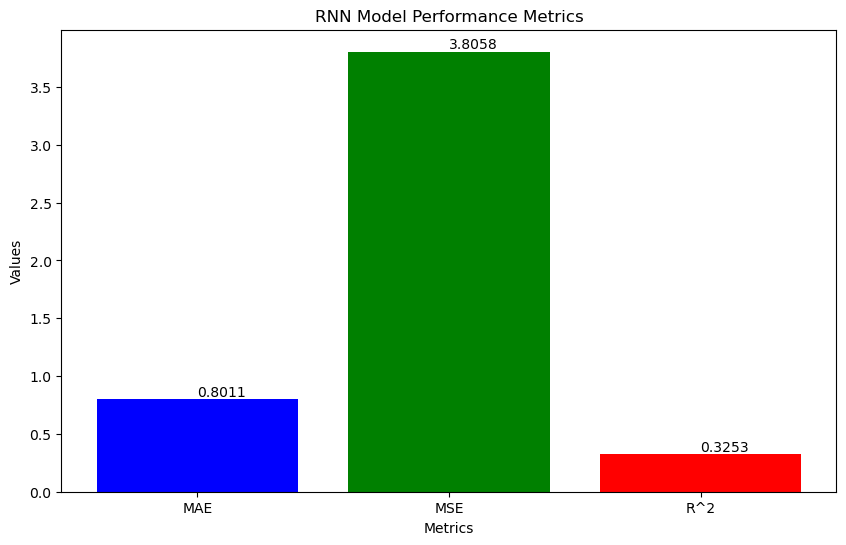

In [14]:
# 성능 평가 지표를 리스트로 정리
model = ['RNN', 'RNN', 'RNN']
metrics = ['MAE', 'MSE', 'R^2']
values = [rnn_mae, rnn_mse, rnn_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RNN Model Performance Metrics')
plt.show()

#### 2-2. LSTM Modeling

In [15]:
# LSTM 모델 빌드
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

# LSTM 모델 학습
lstm_history = lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 평가
lstm_loss = lstm_model.evaluate(X_test, y_test)
print('LSTM Test Loss:', lstm_loss)

# 예측값
lstm_predictions = lstm_model.predict(X_test)

# 평가지표
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

print('RNN Test MAE:', lstm_mae)
print('RNN Test MSE:', lstm_mse)
print('RNN Test R^2:', lstm_r2)

Epoch 1/50


/home/hwchoi/anaconda3/envs/kdca/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.7678 - val_loss: 4.1514
Epoch 2/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.5051 - val_loss: 3.9096
Epoch 3/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1323 - val_loss: 4.0083
Epoch 4/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3484 - val_loss: 4.0860
Epoch 5/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7274 - val_loss: 4.1120
Epoch 6/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3760 - val_loss: 3.9024
Epoch 7/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7541 - val_loss: 3.8789
Epoch 8/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.1492 - val_loss: 3.8336
Epoch 9/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.9558 - val_loss: 4.2439
Epoch 10/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7101 - val_loss: 3.8452
Epoch 11/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.8897 - val_loss: 3.8514
Epoch 12/50
650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.

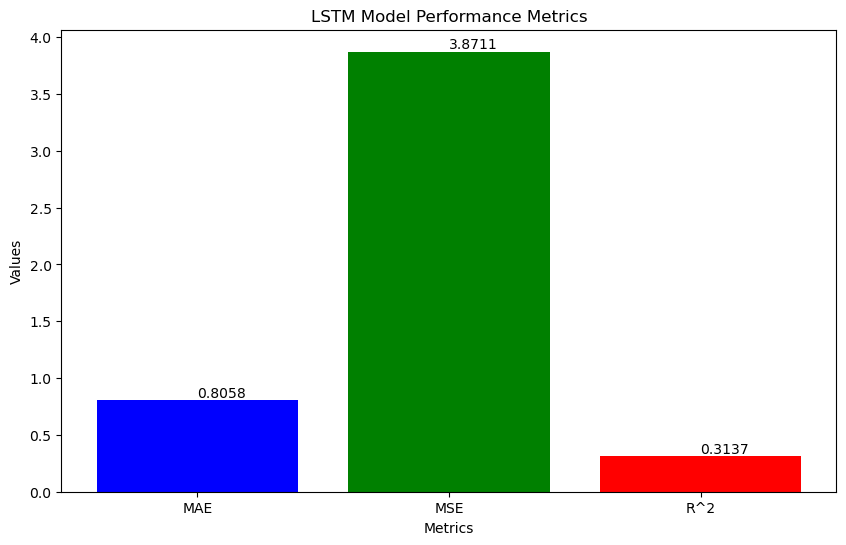

In [16]:
# 성능 평가 지표를 리스트로 정리
model = ['LSTM', 'LSTM', 'LSTM']
metrics = ['MAE', 'MSE', 'R^2']
values = [lstm_mae, lstm_mse, lstm_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('LSTM Model Performance Metrics')
plt.show()

#### 2-3. RandomForest Modeling

In [17]:
# randomforest, xgboost는 flatten 과정 필요
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# RF 모델 빌드
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_flat, y_train)

# RF 평가 지표
rf_predictions = rf_model.predict(X_test_flat)
rf_mse = mean_squared_error(y_test, rf_predictions)
print('RandomForest Test MSE:', rf_mse)

# 추가 평가 지표 
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print('RandomForest Test MAE:', rf_mae)
print('RandomForest Test MSE:', rf_mse)
print('RandomForest Test R^2:', rf_r2)

RandomForest Test MSE: 3.9851320253894977
RandomForest Test MAE: 0.8526139642238891
RandomForest Test MSE: 3.9851320253894977
RandomForest Test R^2: 0.29351875452944376


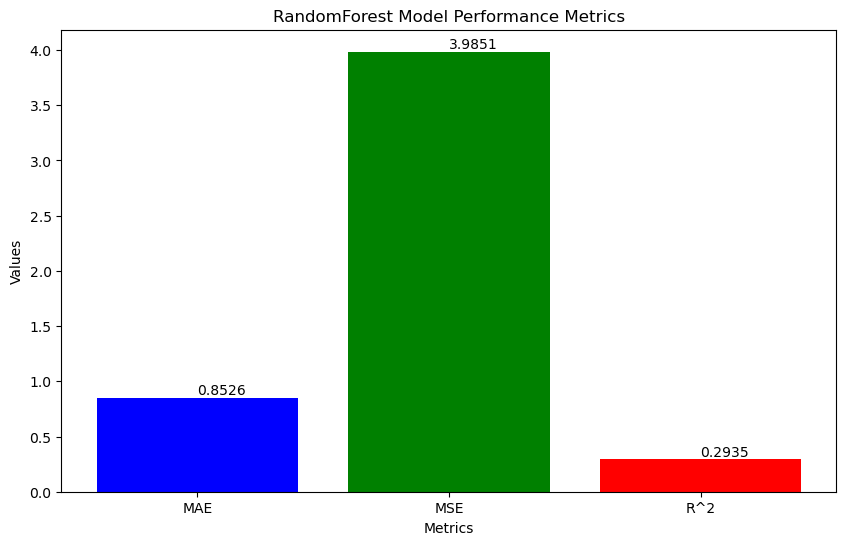

In [18]:
# 성능 평가 지표를 리스트로 정리
model = ['RandomForest', 'RandomForest', 'RandomForest']
metrics = ['MAE', 'MSE', 'R^2']
values = [rf_mae, rf_mse, rf_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('RandomForest Model Performance Metrics')
plt.show()

#### 2-4. XGBoost Regressor Modeling

In [19]:
# XGBoost 모델 빌드
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_flat, y_train)

# XGBoost 모델
xgb_predictions = xgb_model.predict(X_test_flat)
xgb_mse = mean_squared_error(y_test, xgb_predictions)

# 추가 평가지표 계산
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost Test MAE:', xgb_mae)
print('XGBoost Test MSE:', xgb_mse)
print('XGBoost Test R^2:', xgb_r2)

XGBoost Test MAE: 0.8145417310226731
XGBoost Test MSE: 3.918829197260111
XGBoost Test R^2: 0.3052728772163391


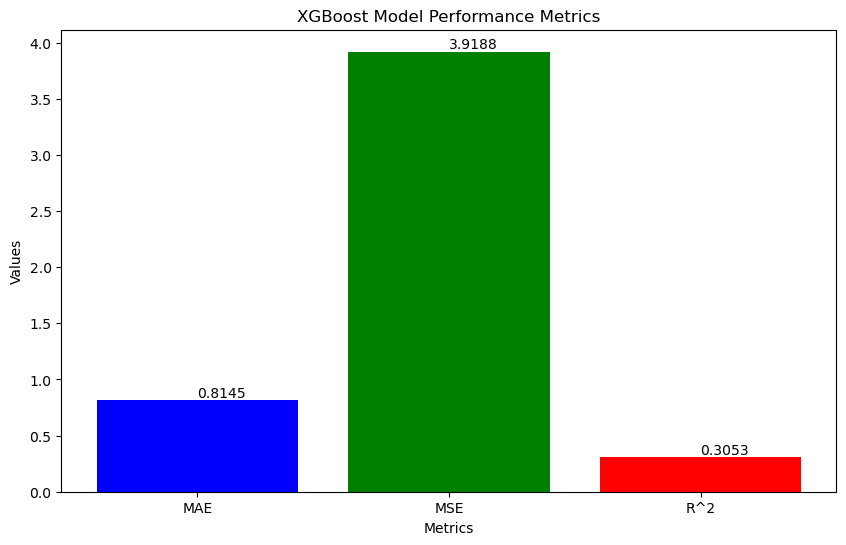

In [20]:
# 성능 평가 지표를 리스트로 정리
model = ['XGB', 'XGB', 'XGB']
metrics = ['MAE', 'MSE', 'R^2']
values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red'])

# 막대 그래프에 값 표시
for bar, value in zip(bars, values):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(value, 4), va='bottom')  # 중앙 정렬 및 값 표시

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('XGBoost Model Performance Metrics')
plt.show()

#### 2-5. RNN, LSTM, RandomForest, XGBoost 평가지표 시각화

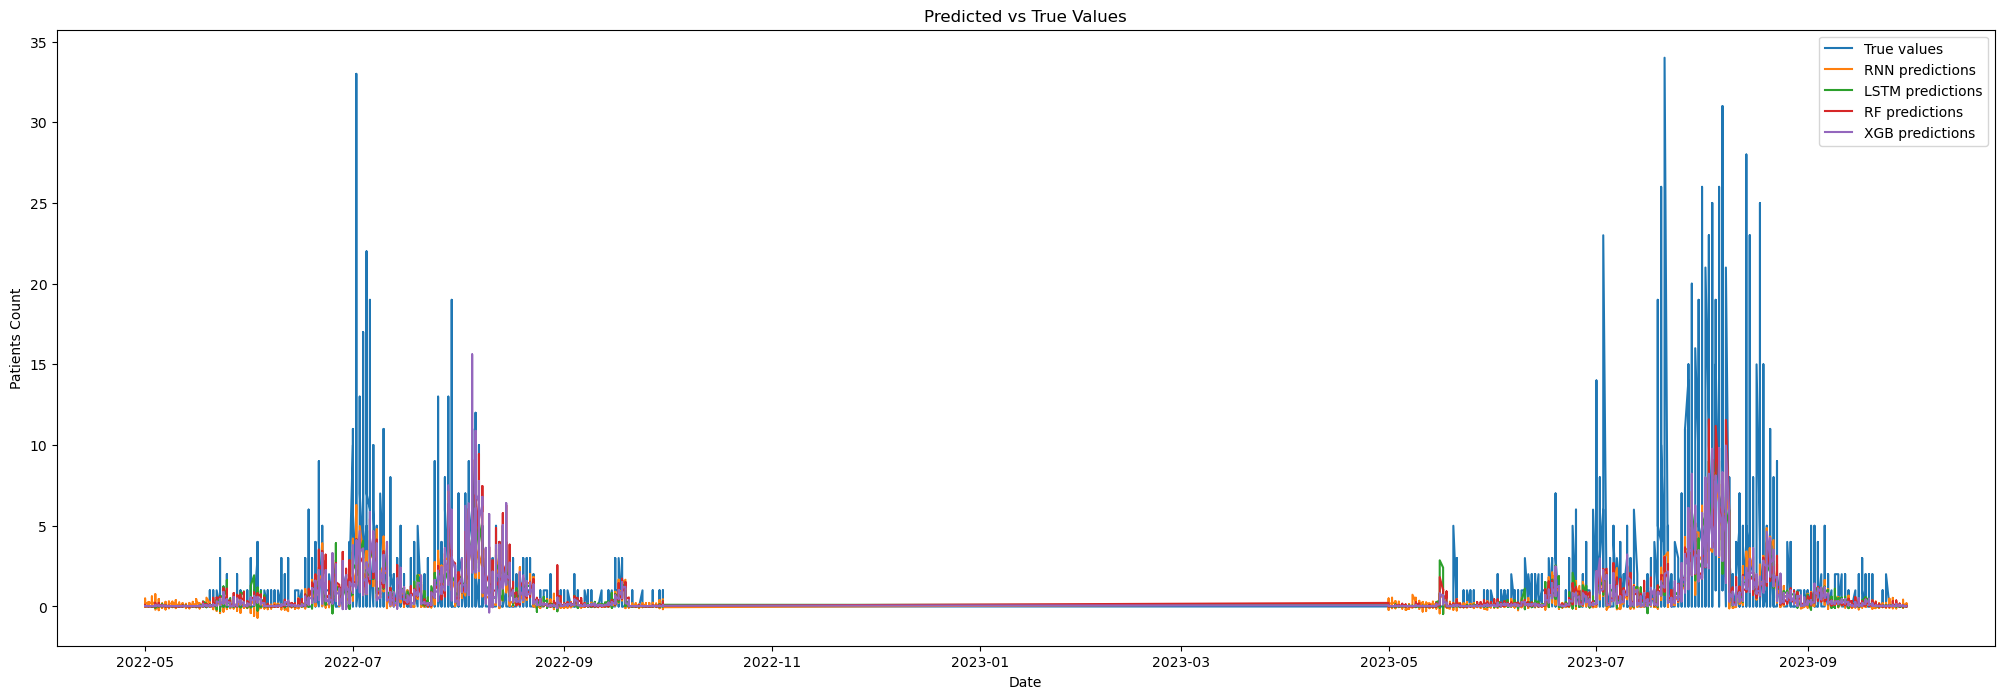

In [22]:
# 결과 시각화
plt.figure(figsize=(25, 8))
plt.plot(dates_test, y_test, label='True values')
plt.plot(dates_test, rnn_predictions, label='RNN predictions')
plt.plot(dates_test, lstm_predictions, label='LSTM predictions')
plt.plot(dates_test, rf_predictions, label='RF predictions')
plt.plot(dates_test, xgb_predictions, label='XGB predictions')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.title('Predicted vs True Values')
plt.legend()
plt.show()

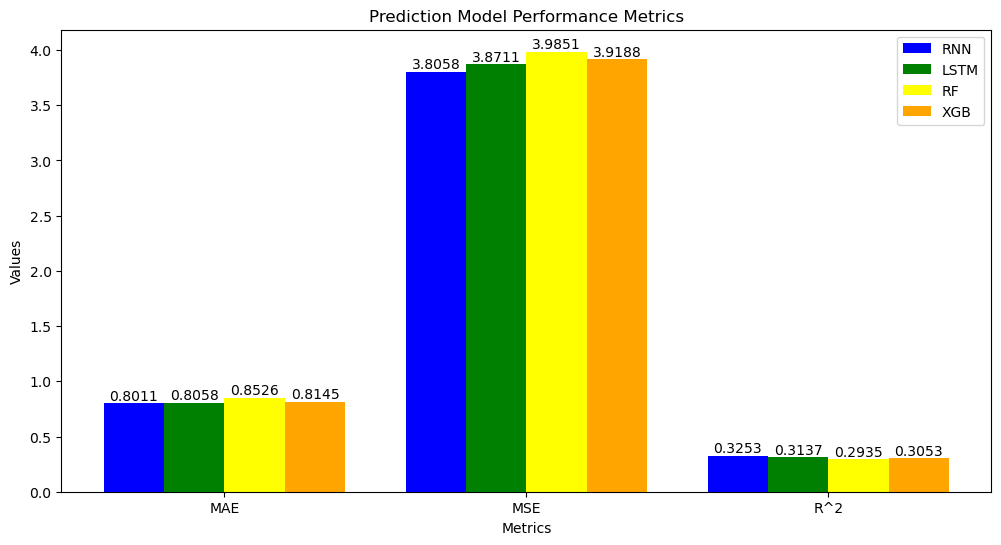

In [23]:
# 성능 평가 지표를 리스트로 정리
metrics = ['MAE', 'MSE', 'R^2']
rnn_values = [rnn_mae, rnn_mse, rnn_r2]
lstm_values = [lstm_mae, lstm_mse, lstm_r2]
rf_values = [rf_mae, rf_mse, rf_r2]
xgb_values = [xgb_mae, xgb_mse, xgb_r2]

# 시각화
x = np.arange(len(metrics))  # 각 지표에 대한 레이블 위치
width = 0.2  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 1.5 * width, rnn_values, width, label='RNN', color='blue')
bars2 = ax.bar(x - 0.5 * width, lstm_values, width, label='LSTM', color='green')
bars3 = ax.bar(x + 0.5 * width, rf_values, width, label='RF', color='yellow')
bars4 = ax.bar(x + 1.5 * width, xgb_values, width, label='XGB', color='orange')

# 막대 그래프에 값 표시
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)
add_labels(bars4)

# 레이블 및 제목 설정
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Prediction Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.savefig('Prediction Model Performance Metrics.png')
plt.show()